# Data Import & Cleaning

In [28]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from pathlib import Path
from google_ads_cleaning import clean_google_ads_data, setup_logging

# Campaign Performance Import & Cleaning

In [29]:
# Setup logging
setup_logging()

# Define file paths
google_ads_input = os.path.join("Resources", "Campaign performance.csv")
google_ads_output = os.path.join("Resources", "cleaned_google_ads_data.csv")
ga4_data_path = os.path.join("Resources", "cleaned_google_analytics_data.csv")

# Clean and process Google Ads data
print("Cleaning Google Ads data...")
ads_df, ads_summary = clean_google_ads_data(google_ads_input, google_ads_output)

2025-03-16 19:32:25,409 - INFO - Starting Google Ads data cleaning process
2025-03-16 19:32:25,415 - INFO - Loaded 49 rows from Resources\Campaign performance.csv
2025-03-16 19:32:25,415 - INFO - Original columns: ['Year', 'Month', 'Currency code', 'Cost', 'Clicks', 'Impr.', 'CTR', 'Avg. CPC', 'Revenue', 'Conversions', 'Conv. rate']
2025-03-16 19:32:25,422 - INFO - 
Data Validation Results:
2025-03-16 19:32:25,422 - INFO - 
Missing values:
2025-03-16 19:32:25,422 - INFO - Year      0
Month     0
Cost      0
Clicks    0
Impr.     0
CPC       0
CTR       0
dtype: int64
2025-03-16 19:32:25,422 - INFO - 
Negative values:
2025-03-16 19:32:25,426 - INFO - {'Cost': 0, 'Clicks': 0, 'Impr.': 0}
2025-03-16 19:32:25,426 - INFO - 
Zero impressions:
2025-03-16 19:32:25,426 - INFO - 0
2025-03-16 19:32:25,428 - INFO - 
Invalid CPC:
2025-03-16 19:32:25,428 - INFO - 0
2025-03-16 19:32:25,431 - INFO - 
Summary Statistics:
2025-03-16 19:32:25,438 - INFO - 
Monthly averages:
2025-03-16 19:32:25,439 - INFO

Cleaning Google Ads data...


In [30]:
# Load GA4 data
print("Loading GA4 data...")
ga4_df = pd.read_csv(ga4_data_path)

# Convert month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
ga4_df['Month'] = ga4_df['Month'].map(month_map)

# Create datetime column for GA4 data
ga4_df['Date'] = pd.to_datetime(ga4_df[['Year', 'Month']].assign(Day=1))

# Aggregate GA4 data by date and channel
ga4_metrics = ga4_df.groupby(['Date', 'Channel']).agg({
    'Sessions': 'sum',
    'Engaged sessions': 'sum',
    'Event count': 'sum',
    'Total revenue': 'sum'
}).reset_index()

# Calculate engagement rate
ga4_metrics['Engagement rate'] = (ga4_metrics['Engaged sessions'] / ga4_metrics['Sessions'] * 100).round(2)

Loading GA4 data...


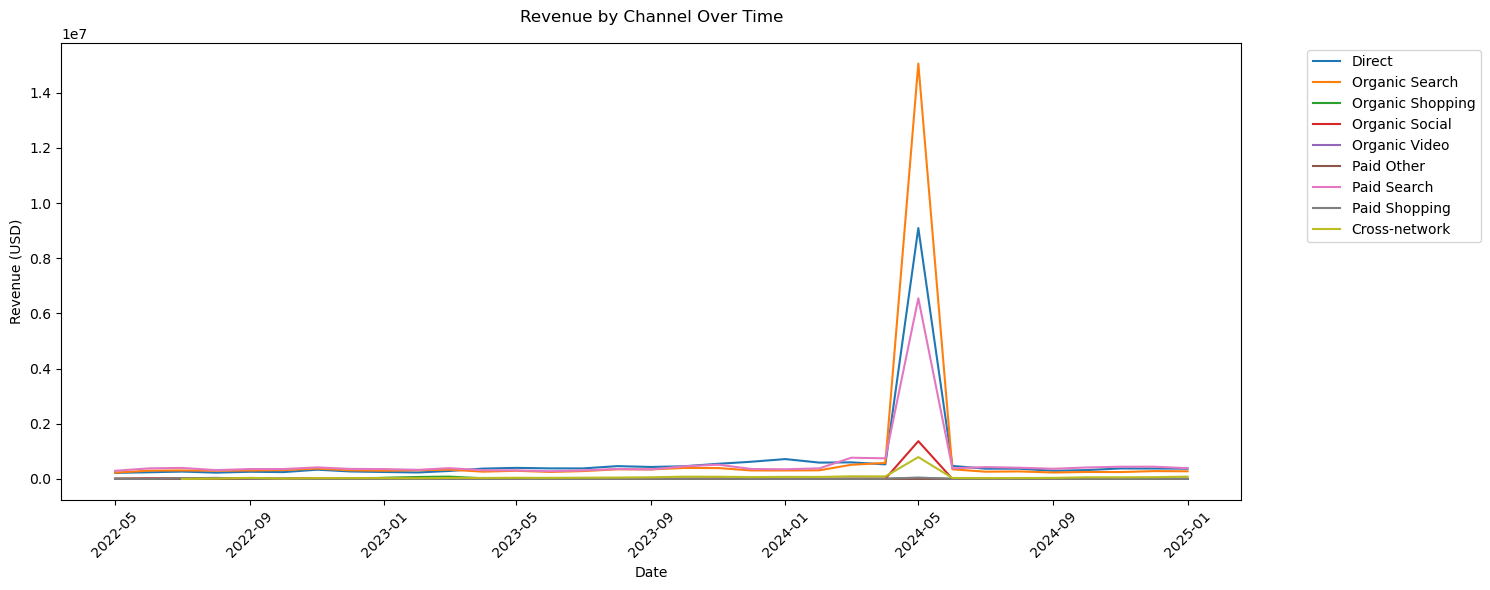

In [31]:
# 1. Channel Revenue Comparison
plt.figure(figsize=(15, 6))
sns.lineplot(data=ga4_metrics, x='Date', y='Total revenue', hue='Channel')
plt.title('Revenue by Channel Over Time', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Revenue (USD)', fontsize=10)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

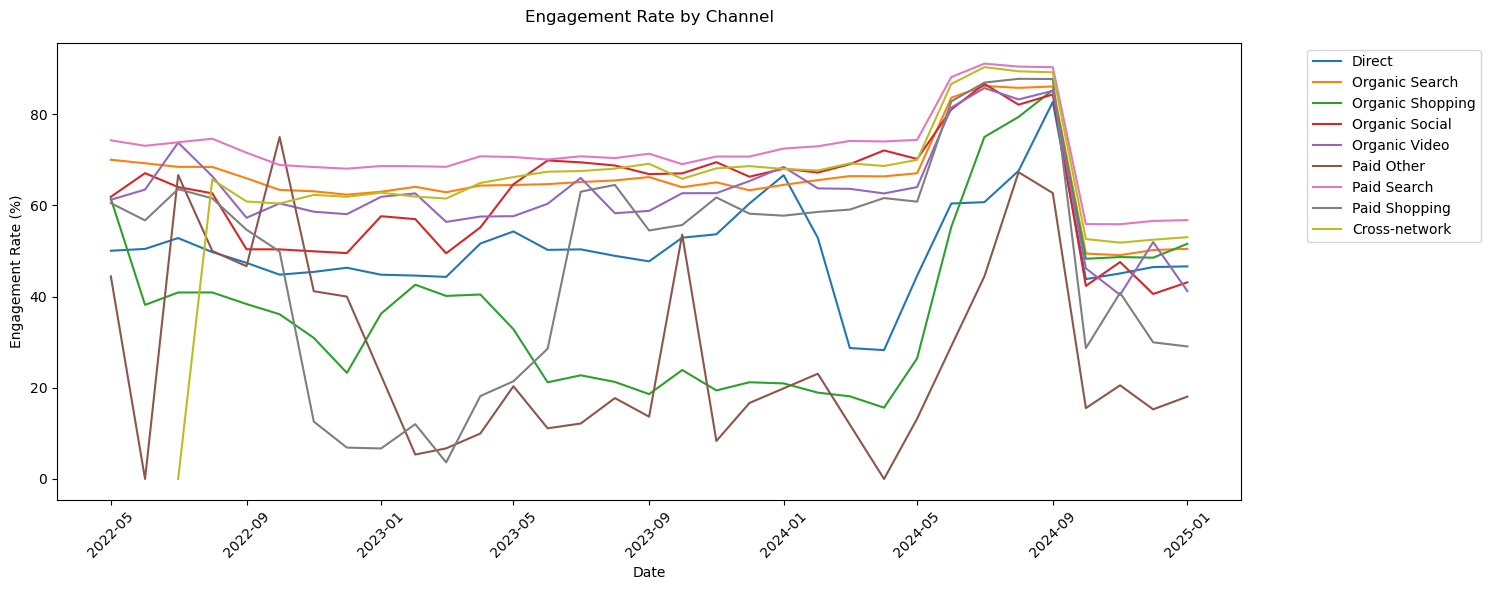

In [32]:
# 2. Channel Engagement Comparison
plt.figure(figsize=(15, 6))
sns.lineplot(data=ga4_metrics, x='Date', y='Engagement rate', hue='Channel')
plt.title('Engagement Rate by Channel', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Engagement Rate (%)', fontsize=10)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
# 3. Channel Performance Matrix
channel_summary = ga4_metrics.groupby('Channel').agg({
    'Sessions': 'sum',
    'Engaged sessions': 'sum',
    'Total revenue': 'sum',
    'Engagement rate': 'mean'
}).round(2)

# Add revenue per session
channel_summary['Revenue per Session'] = (channel_summary['Total revenue'] / channel_summary['Sessions']).round(2)

print("\nChannel Performance Summary:")
display(channel_summary.sort_values('Total revenue', ascending=False))


Channel Performance Summary:


,Sessions,Engaged sessions,Total revenue,Engagement rate,Revenue per Session
Channel,,,,,
Organic Search,7009965,4544913,25250999.32,65.90,3.60
Direct,6679278,3350919,21424803.35,50.47,3.21
Paid Search,4856540,3428086,19329336.69,71.70,3.98
Cross-network,969968,632214,2268837.66,64.92,2.34
Organic Social,588315,337215,1701367.97,62.79,2.89
Organic Shopping,109607,43421,376873.82,37.67,3.44
Paid Shopping,130411,83586,166909.78,48.07,1.28
Organic Video,28910,17627,36325.07,62.65,1.26
Paid Other,13367,2905,2029.61,28.30,0.15


<Figure size 1500x600 with 0 Axes>

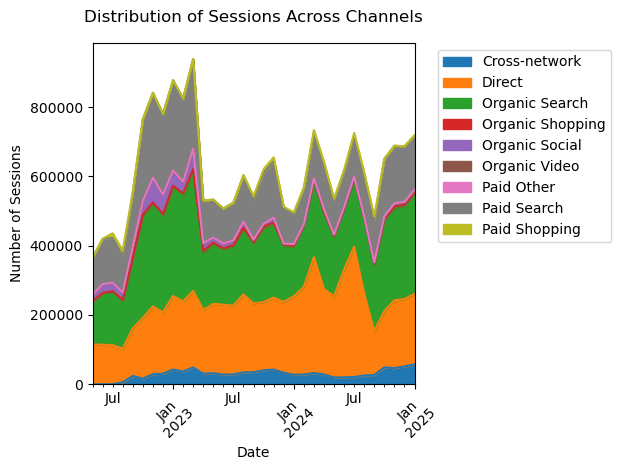

In [34]:
# 4. Stacked Area Chart of Sessions by Channel
pivot_sessions = ga4_metrics.pivot(index='Date', columns='Channel', values='Sessions')
plt.figure(figsize=(15, 6))
pivot_sessions.plot(kind='area', stacked=True)
plt.title('Distribution of Sessions Across Channels', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Number of Sessions', fontsize=10)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
# 5. Compare Paid Search Performance (Google Ads vs GA4)
paid_search_ga4 = ga4_metrics[ga4_metrics['Channel'] == 'Paid Search'].copy()
paid_search_comparison = pd.merge(
    ads_df[['Date', 'Cost', 'Clicks']],
    paid_search_ga4[['Date', 'Sessions', 'Total revenue']],
    on='Date',
    how='inner'
)

In [36]:
# Calculate ROAS
paid_search_comparison['ROAS'] = (paid_search_comparison['Total revenue'] / paid_search_comparison['Cost'] * 100).round(2)

print("\nPaid Search Performance Metrics:")
display(paid_search_comparison.describe().round(2))


Paid Search Performance Metrics:


,Date,Cost,Clicks,Sessions,Total revenue,ROAS
count,33,33.00,33.00,33.00,33.00,33.00
mean,2023-08-31 21:05:27.272727296,64807.12,128070.97,147167.88,585737.48,885.98
min,2022-05-01 00:00:00,37572.79,75619.00,87514.00,280688.95,418.58
25%,2023-01-01 00:00:00,56597.93,112465.00,108887.00,351190.54,517.29
50%,2023-09-01 00:00:00,69539.16,132785.00,129208.00,383586.27,586.23
75%,2024-05-01 00:00:00,74655.30,149076.00,161818.00,419716.35,786.53
max,2025-01-01 00:00:00,89591.67,164170.00,260484.00,6547720.15,8670.87
std,NaN,14052.32,24575.58,51595.39,1075467.39,1409.98


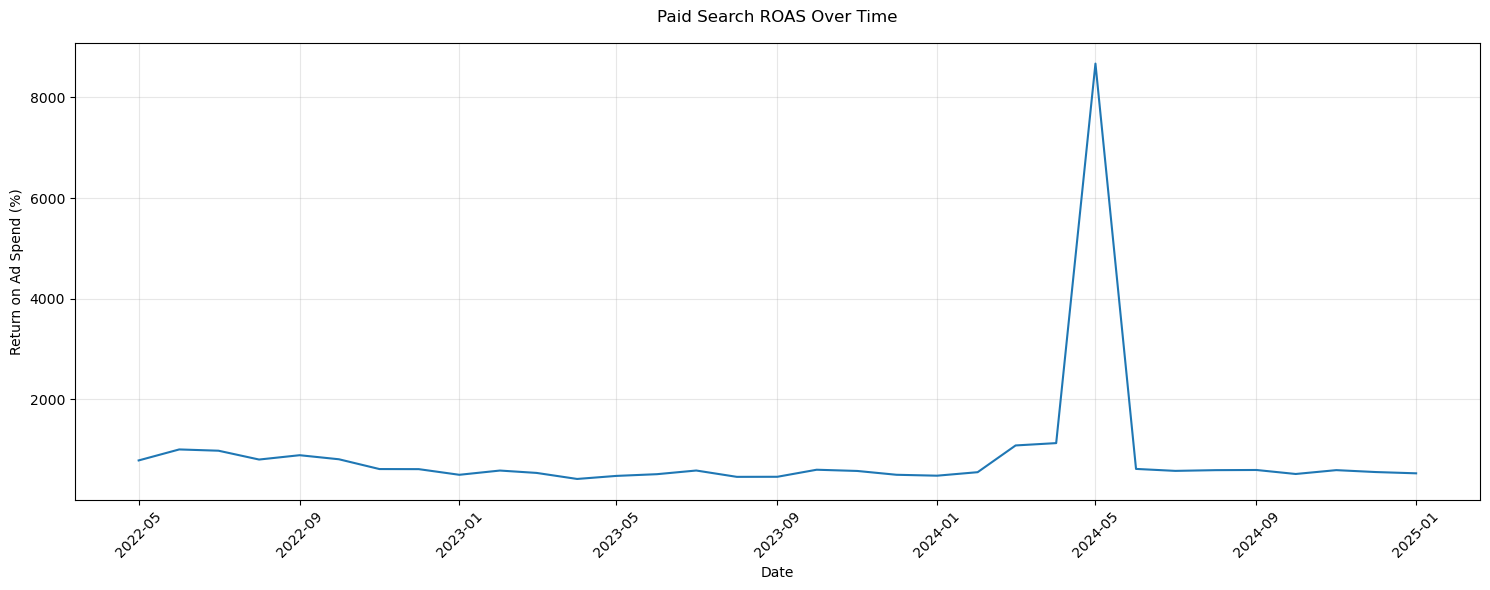


Analysis results saved to Resources\channel_analysis_results.csv


In [37]:
# Plot ROAS over time
plt.figure(figsize=(15, 6))
sns.lineplot(data=paid_search_comparison, x='Date', y='ROAS')
plt.title('Paid Search ROAS Over Time', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Return on Ad Spend (%)', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the combined analysis
output_path = os.path.join("Resources", "channel_analysis_results.csv")
channel_summary.to_csv(output_path)
print(f"\nAnalysis results saved to {output_path}")

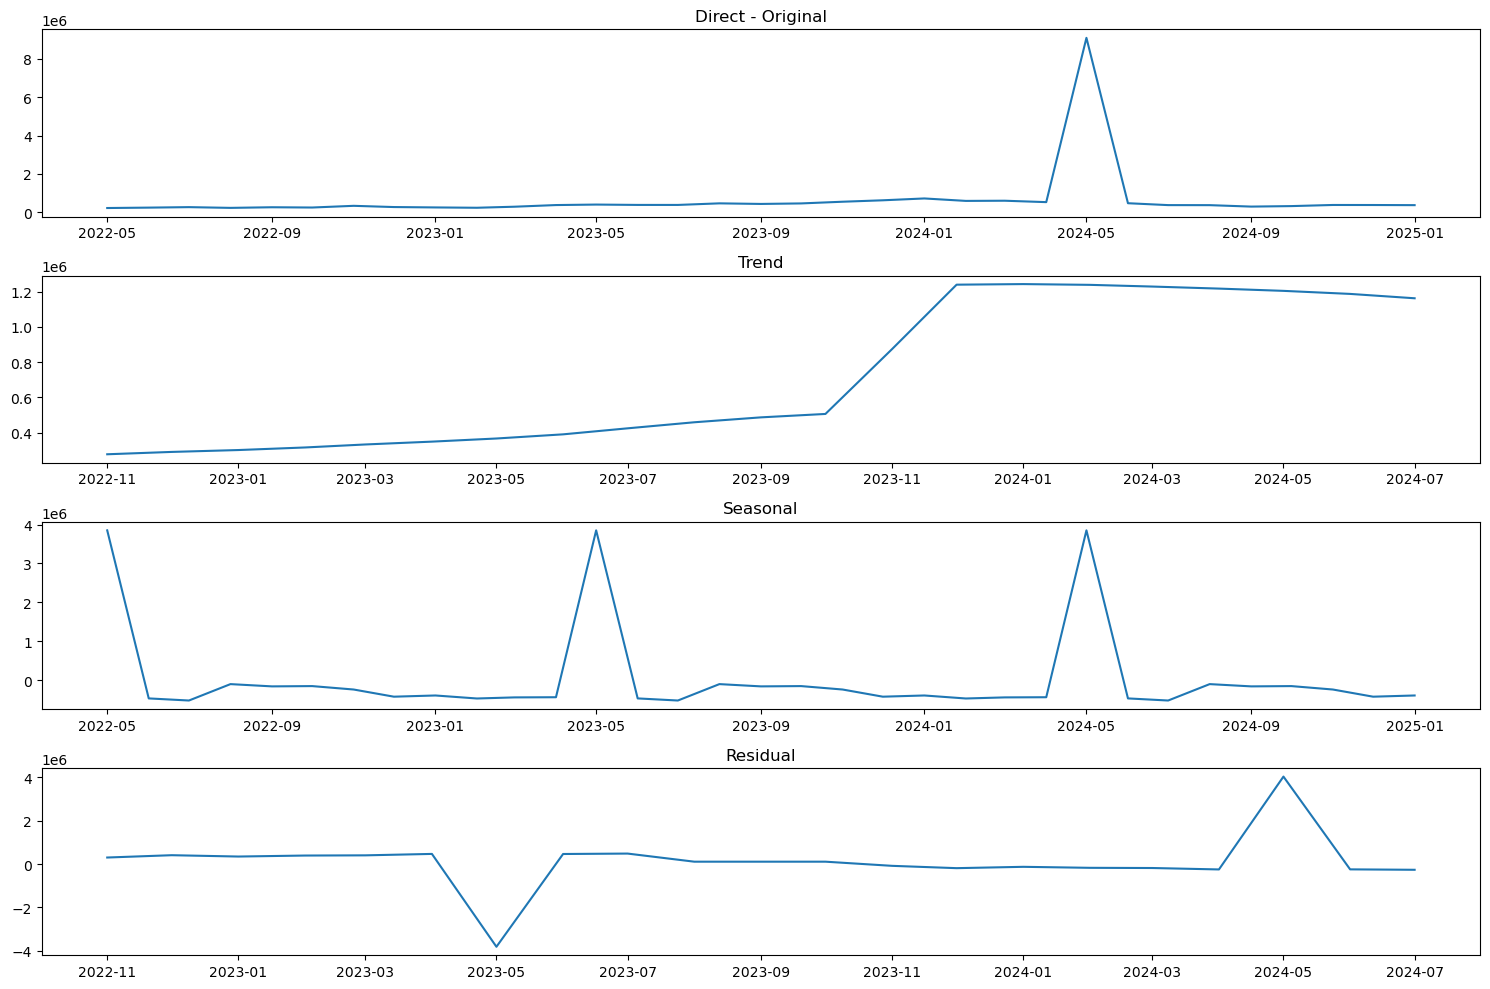

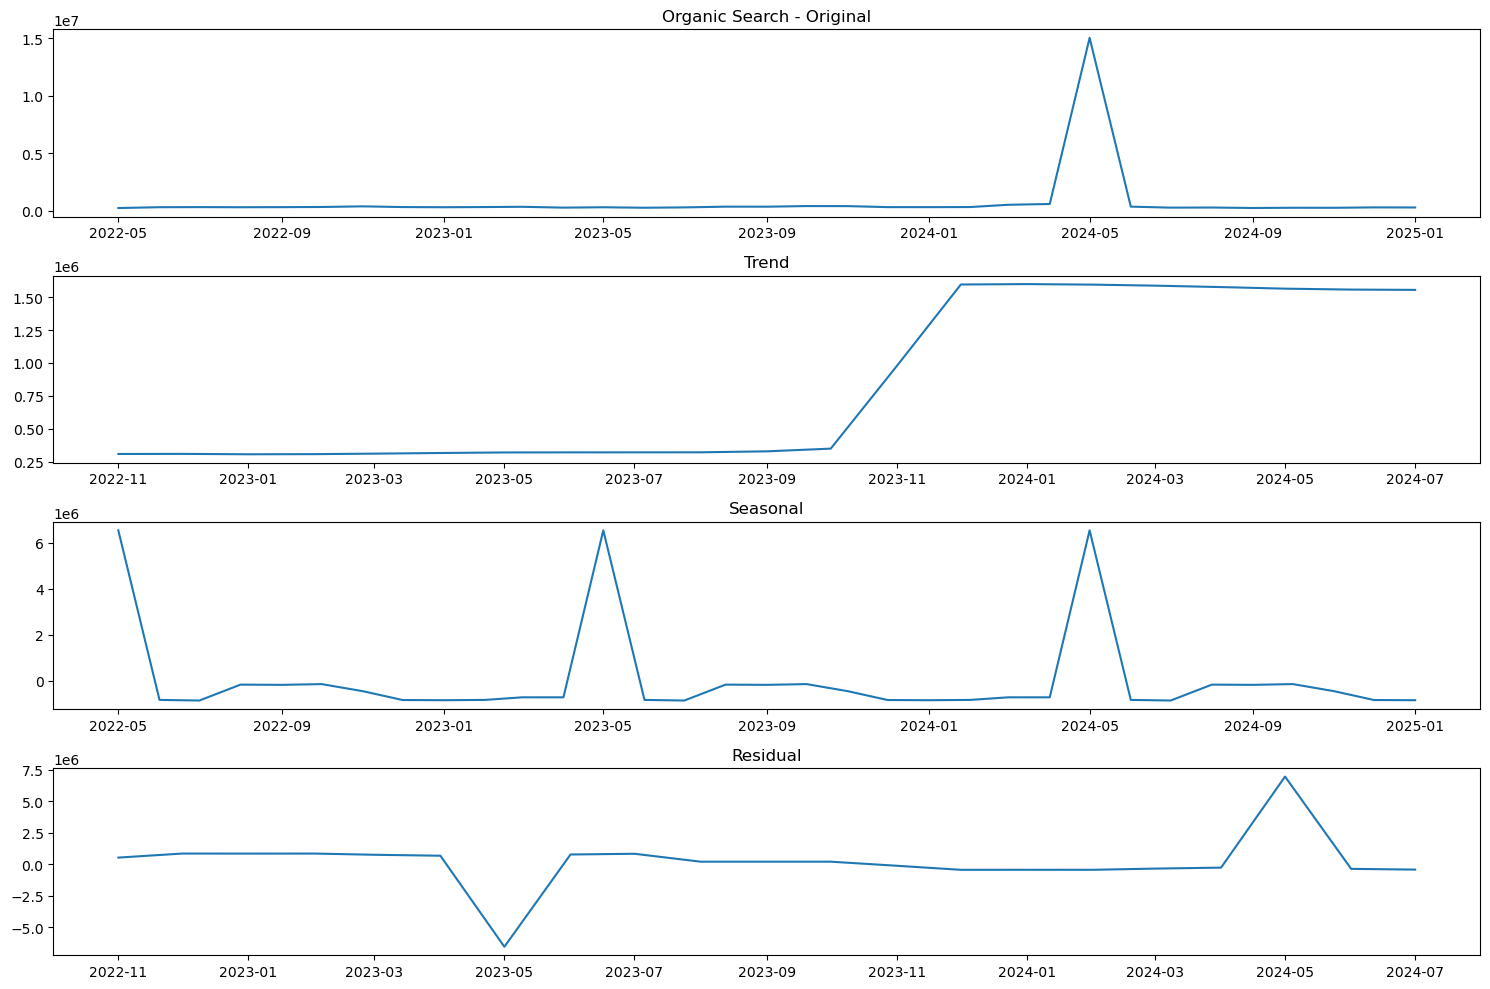

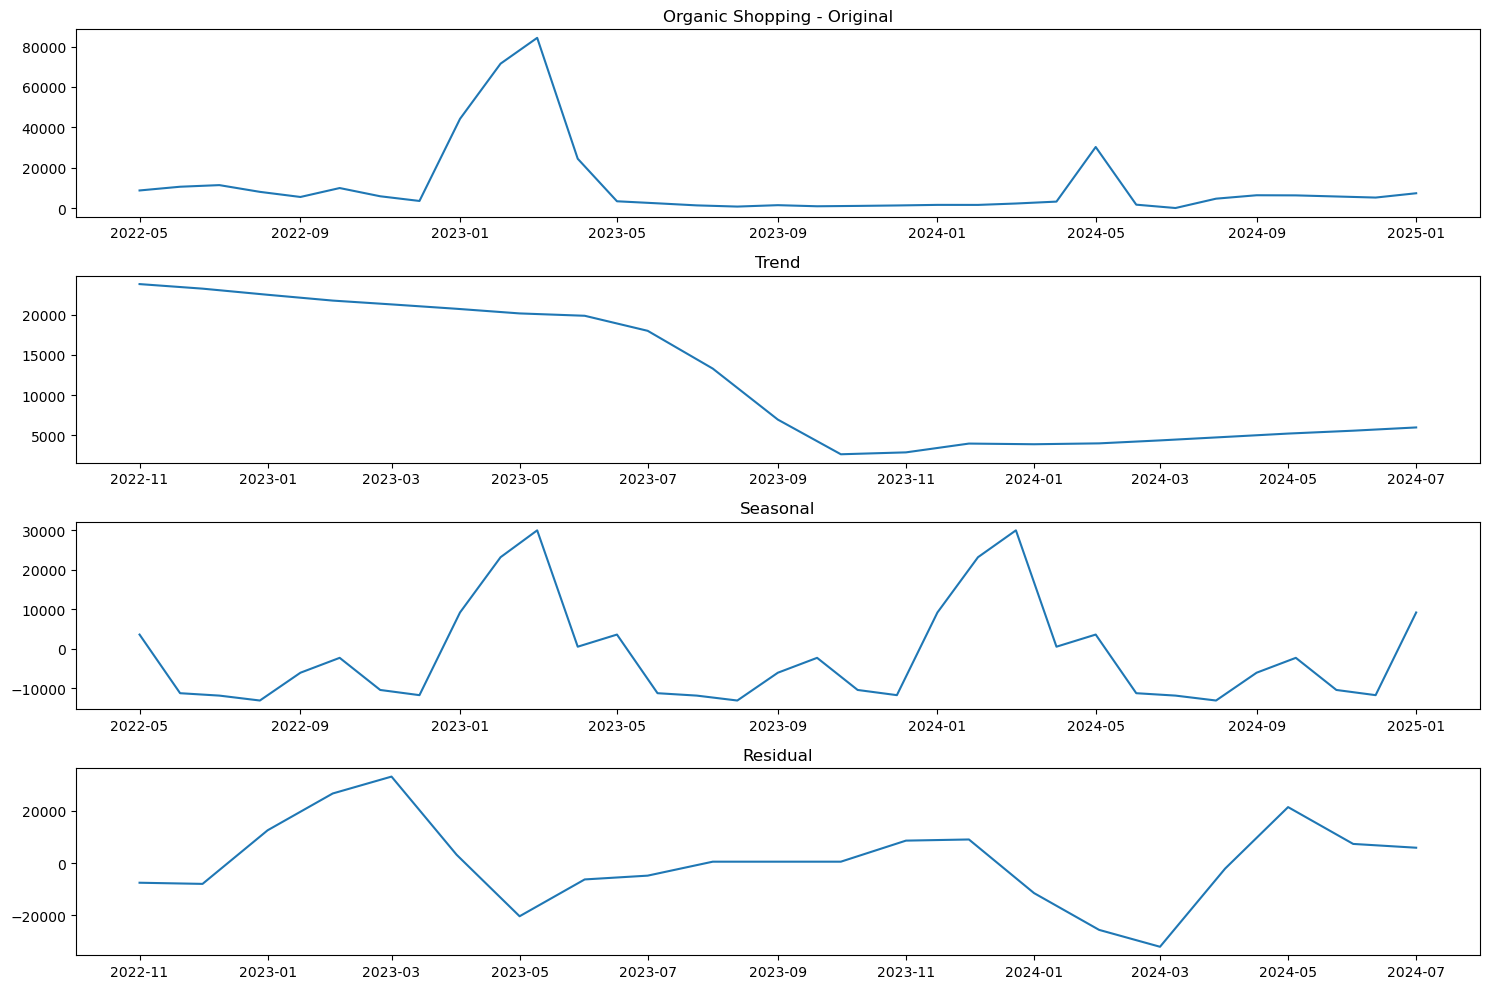

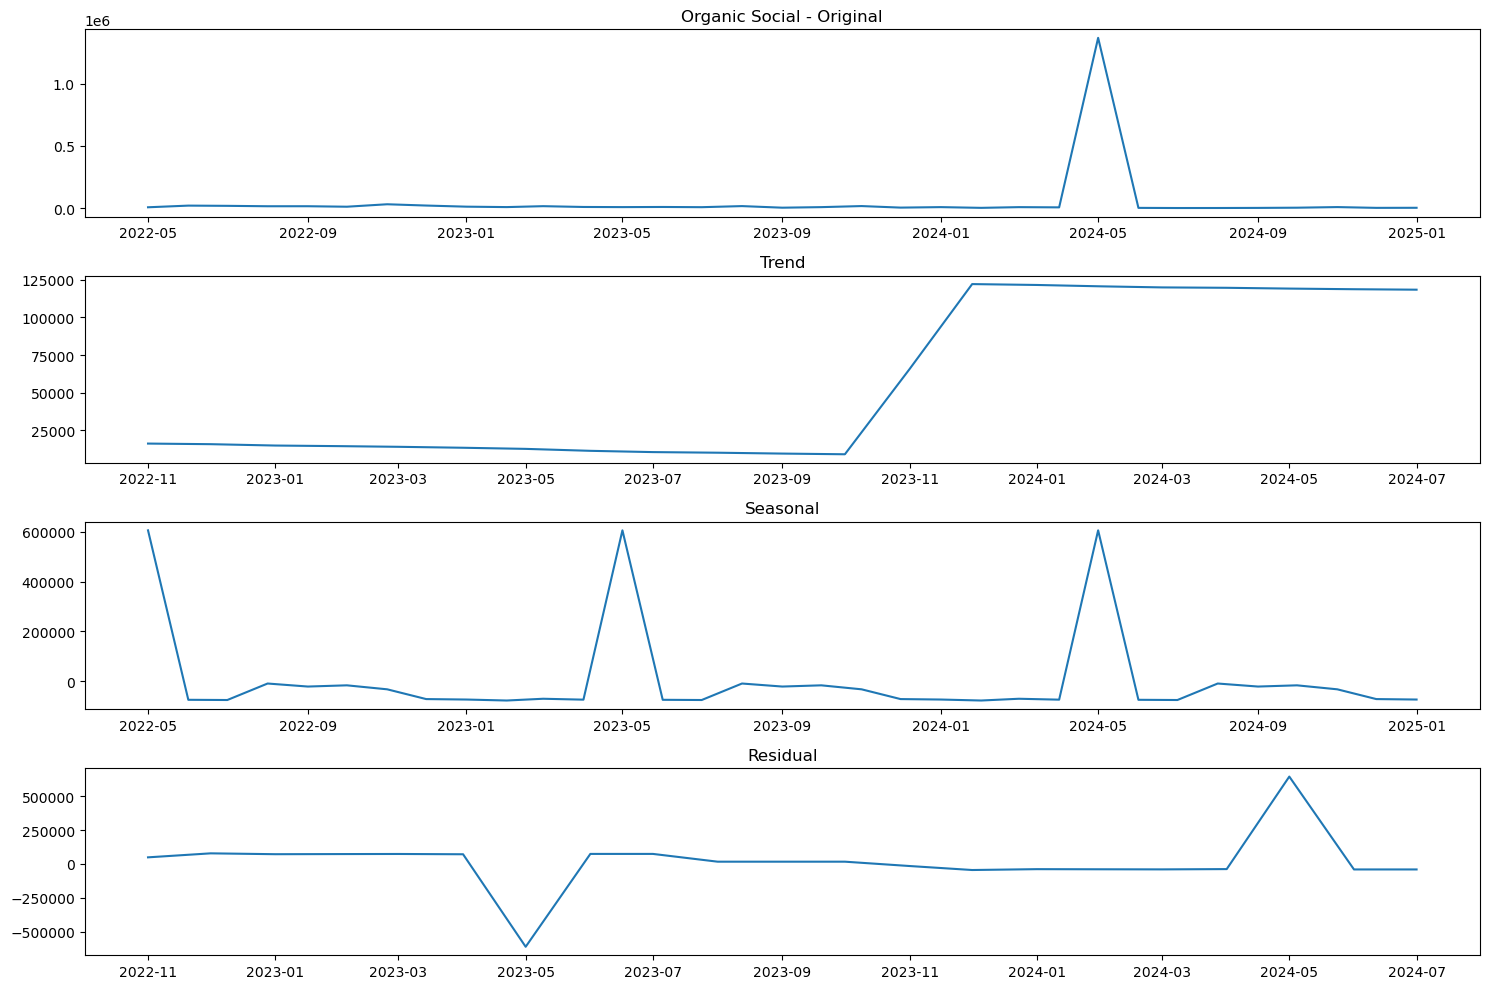

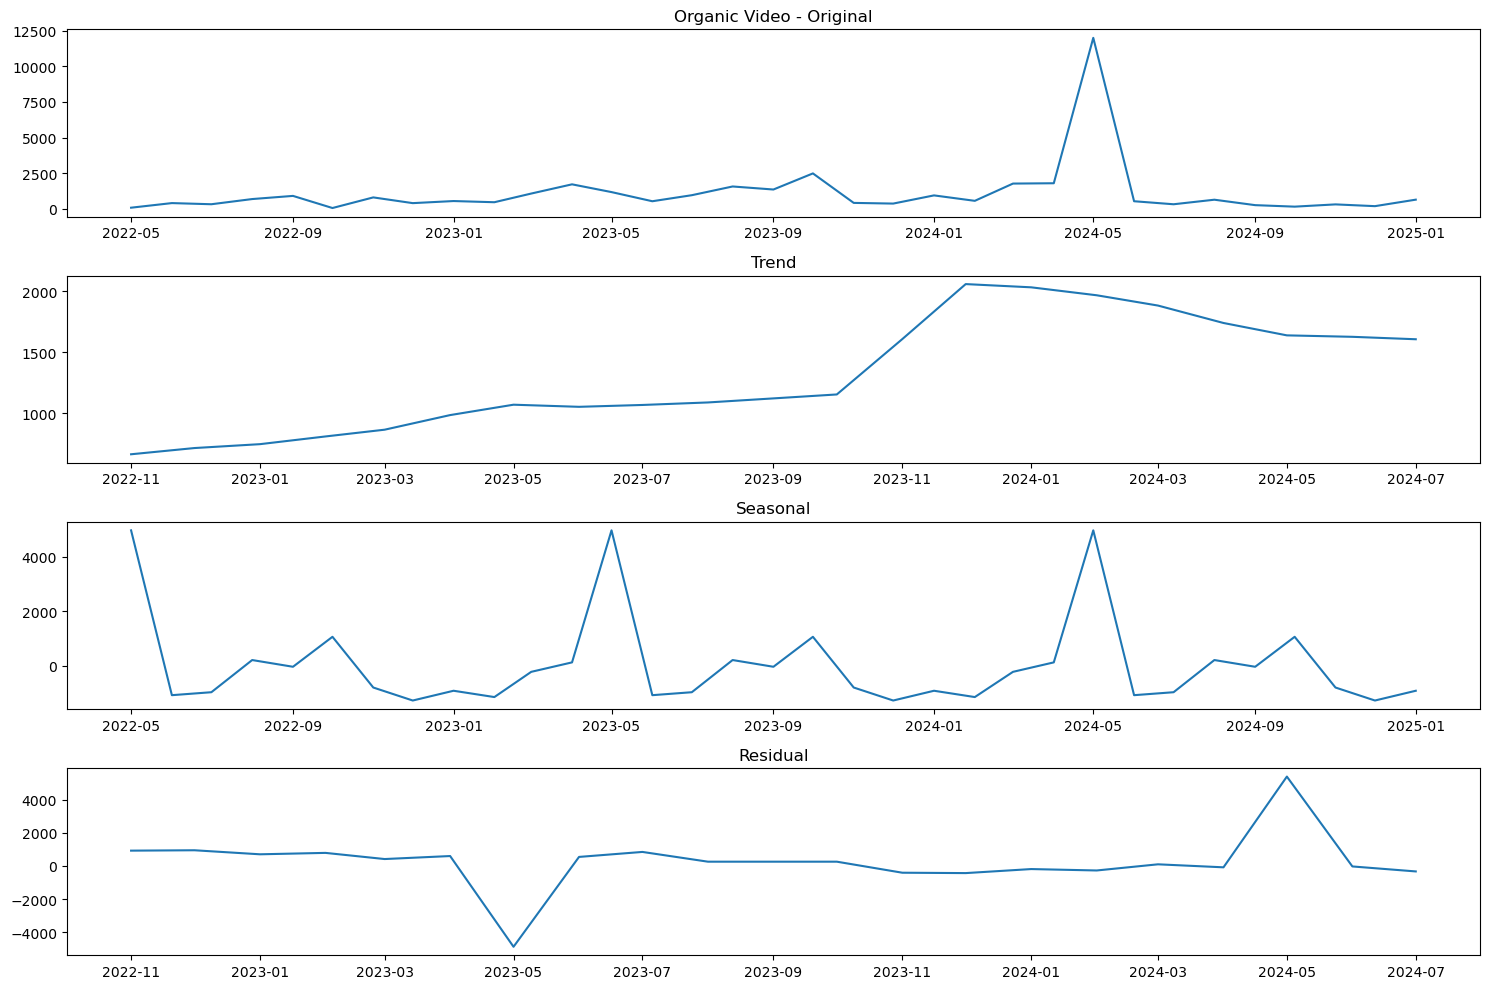

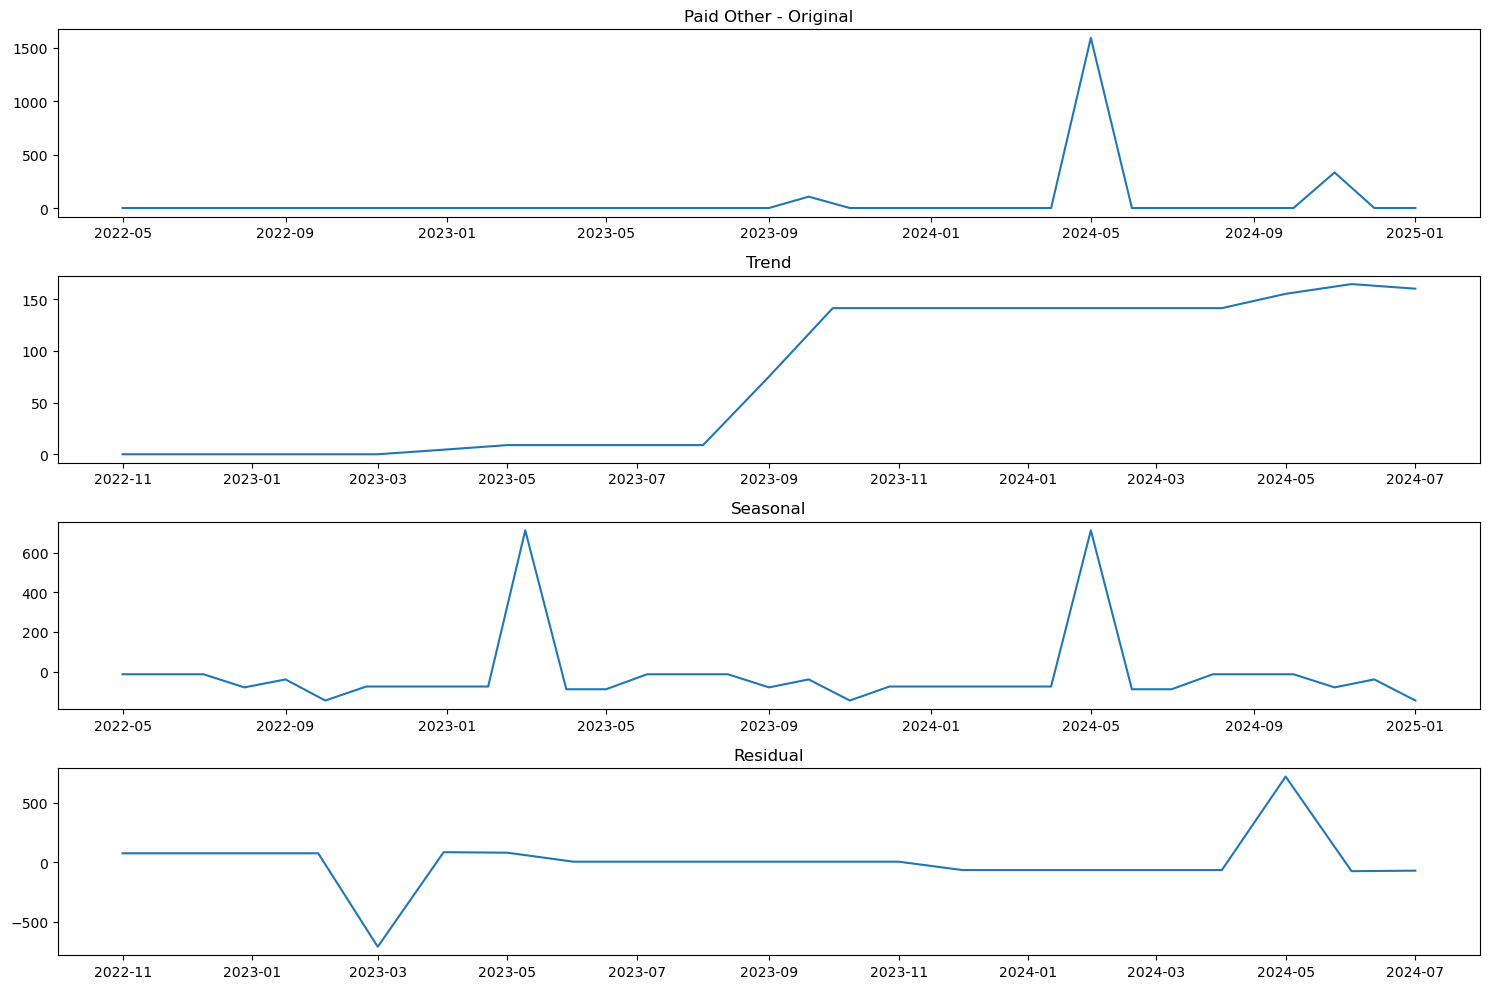

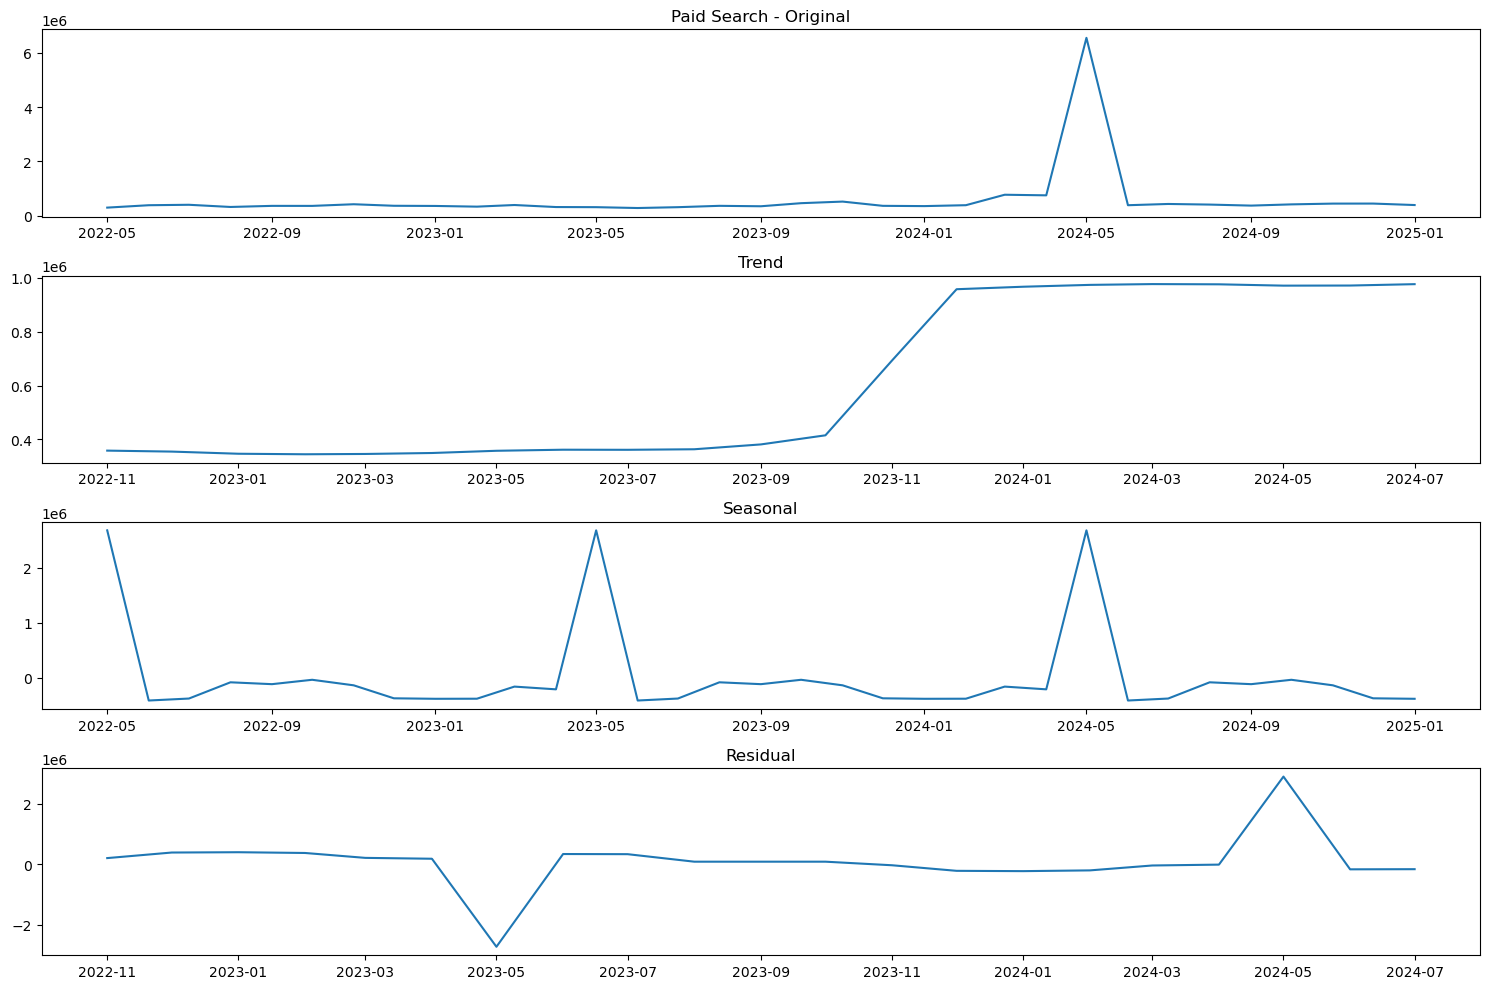

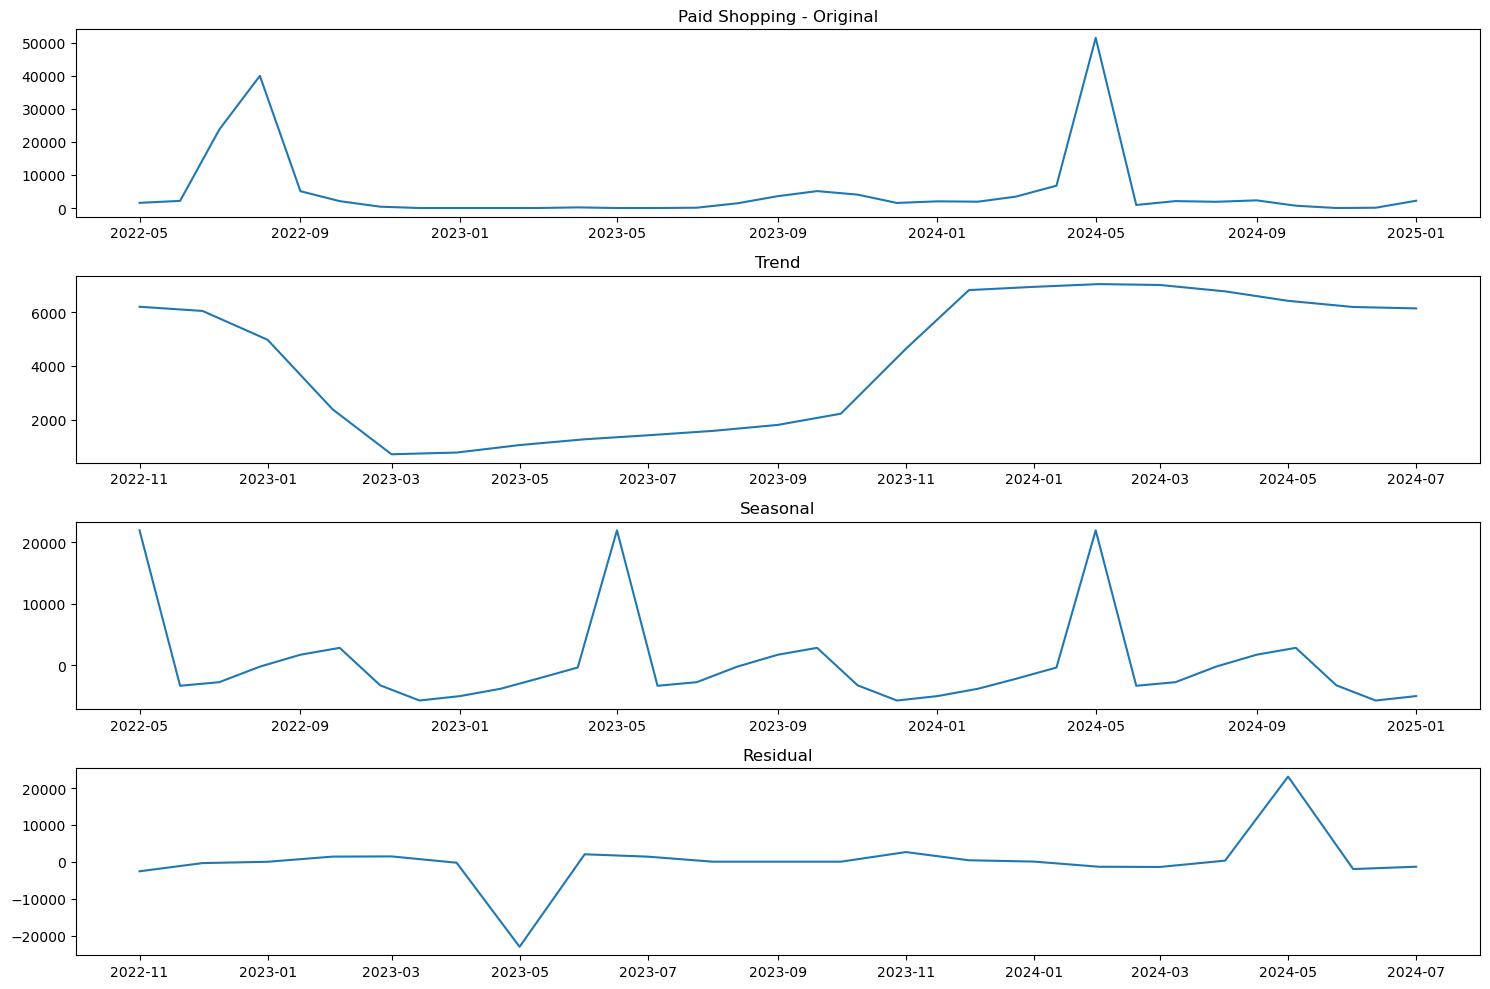

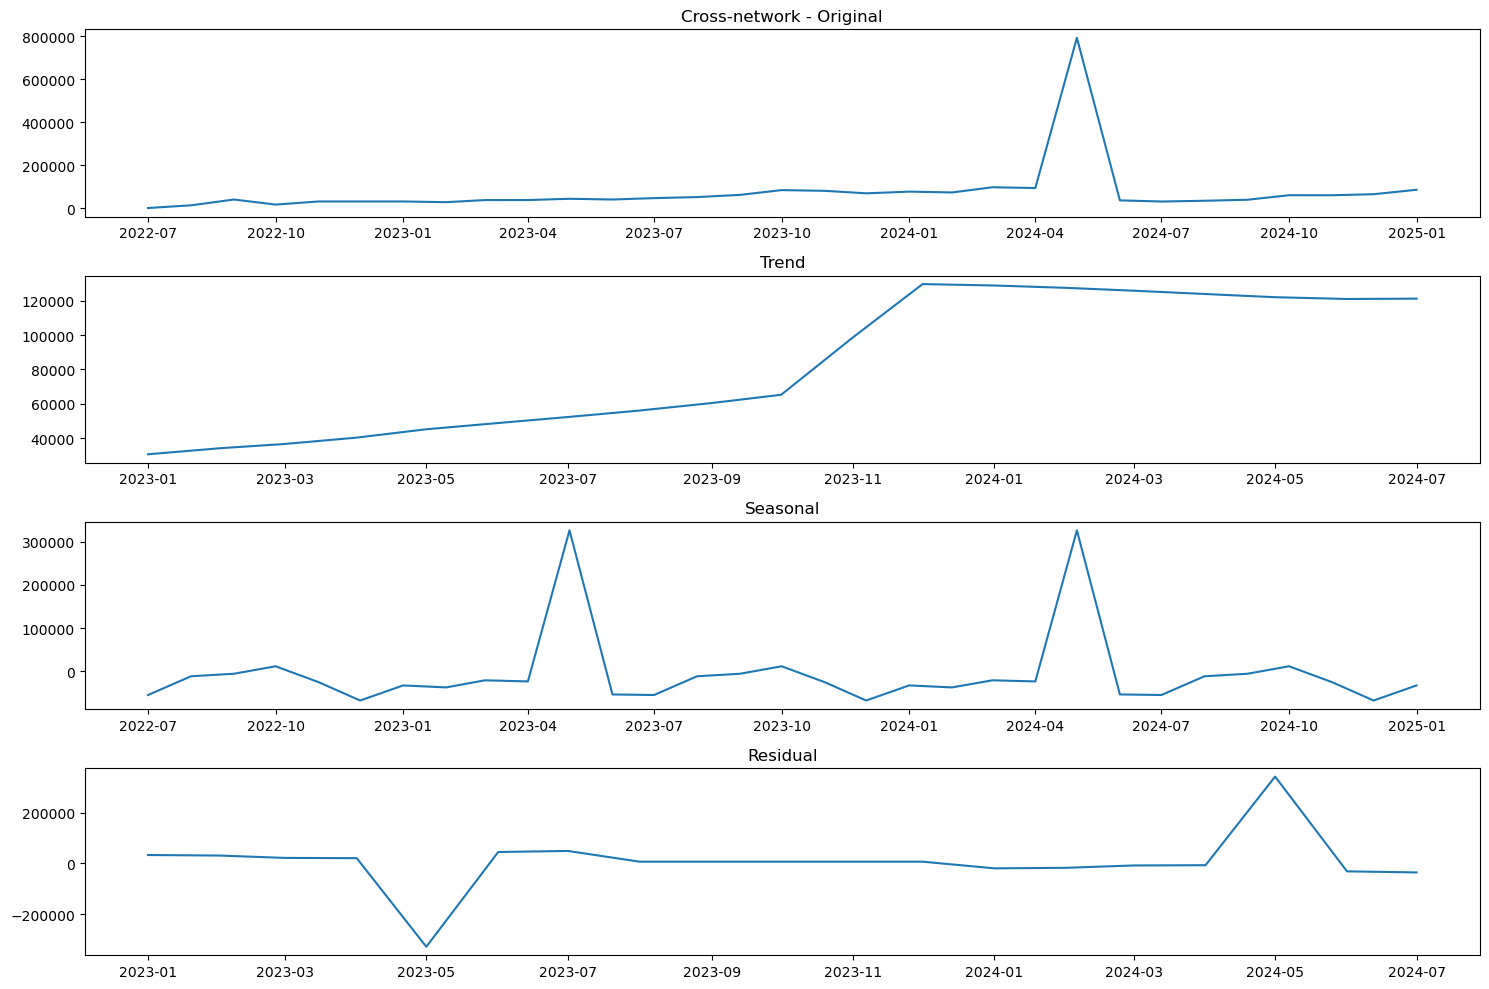

In [39]:
# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition for each channel
for channel in ga4_metrics['Channel'].unique():
    channel_data = ga4_metrics[ga4_metrics['Channel'] == channel].set_index('Date')['Total revenue']
    
    # Only decompose if we have enough data points
    if len(channel_data) > 12:  # Need at least 12 months for yearly seasonality
        decomposition = seasonal_decompose(channel_data, period=12)
        
        # Plot decomposition
        plt.figure(figsize=(15, 10))
        plt.subplot(411)
        plt.plot(channel_data)
        plt.title(f'{channel} - Original')
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        plt.tight_layout()
        plt.show()



In [40]:
# Basic regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare features and target
X = ga4_metrics[['Sessions', 'Engaged sessions', 'Event count']]
y = ga4_metrics['Total revenue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Print results
print("\nChannel Impact Analysis:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"R² Score: {model.score(X_test, y_test):.2f}")


Channel Impact Analysis:
Sessions: 2.92
Engaged sessions: -9.48
Event count: 0.52
R² Score: 0.05
